#Analysis of Tweets by Donald Trump

Donald J. Trump is a real estate mogul, TV celebrity and most notably, former President of the United States. He has had an influencial role in American politics since he announced his candidacy in 2015. Despite the controversy of most of his policies, he was nonetheless elected President in 2016.

Trump was the mouth piece of a large segment of the U.S. population. He composed a suprisingly large number of tweets during his time on Twitter, which ended when the company permanently suspended his account. His Twitter activity can be a useful focal point into the mindset of a political movement in the country, a movement many consider dangerous and reminiscent of fascist regemes of the 20th century. It is unclear if this is the case, though the only way to find out is to study the Trump phenominon.

Due to the massive scale of his tweeting history, manually reading all his tweets would be time-consuming. Therefore, an unsupervised machine learning algorithm is required to quickly extract insights from this corpus. In this particular study, a BERT model is used for the extraction of language features. Cluster analysis is then employed afterwards to identify common topics.  At the end of this study, we should have a better understanding about what Trump and many Americans think regarding politics.

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as showimg
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS 
import pickle

In [ ]:
try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

## Data Description

The dataset of Trump tweets can be downloaded from [Kaggle](https://www.kaggle.com/datasets/headsortails/trump-twitter-archive), which was assembled from Twitter API data. Contained in this dataset are tweets composed from 2009 to 2021. In total, 56,118 are represented in the dataset. Twitter caps the size of posts to a relatively low character count, which has fluctuated over the years. Each tweet should not be longer than 280 characters. In addition to the tweet text, there are other attributes associated with the post (e.g. retweets, favorites(likes), date, etc.). The data file is in CSV format and can be loaded into a DataFrame.

In [ ]:
!mkdir /root/.kaggle
!cp kaggle.json ../root/.kaggle
!ls ../root/.kaggle
!kaggle datasets download -d headsortails/trump-twitter-archive
!unzip -q trump-twitter-archive -d tweets

kaggle.json
  0% 0.00/4.34M [00:00<?, ?B/s]
100% 4.34M/4.34M [00:00<00:00, 180MB/s]


## A Peek into the Data

Below is a basic analysis of data contained in each column of the dataset. Notice that the number of tweets with distinct text is less than the total number of tweets. This suggests that there are tweets that have duplicated text. This is likely not a data issue. It is common for twitter users to create redundant posts (e.g. "Make America Great Again! #MAGA"). However, I think it would be advisable to remove these duplicates because they don't add much value to the analysis. Many duplicate posts may result in topics that are more specific, rather than a broad summary, which a topic should be.

There are not a large number of duplicates, so removal should be ok. However, if there were a lot, then further investigation would be required.

In [ ]:
tweets = pd.read_csv("tweets/trump_tweets.csv")

In [ ]:
tweets.describe(include='all')

,id,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date
count,5.657100e+04,56571,56571,56571,56571,5.657100e+04,56571.000000,56571,56571,56571
unique,NaN,56118,2,2,20,NaN,NaN,56022,2,3500
top,NaN,MAKE AMERICA GREAT AGAIN!,False,False,Twitter for iPhone,NaN,NaN,2020-10-25T19:18:16Z,False,2015-01-05
freq,NaN,51,46694,55479,27967,NaN,NaN,8,56267,160
mean,7.987865e+17,NaN,NaN,NaN,NaN,2.834955e+04,8618.987467,NaN,NaN,NaN
std,3.826616e+17,NaN,NaN,NaN,NaN,5.781564e+04,13306.132408,NaN,NaN,NaN
min,1.698309e+09,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,NaN
25%,4.606192e+17,NaN,NaN,NaN,NaN,1.000000e+01,59.000000,NaN,NaN,NaN
50%,7.471024e+17,NaN,NaN,NaN,NaN,1.640000e+02,3450.000000,NaN,NaN,NaN
75%,1.193134e+18,NaN,NaN,NaN,NaN,4.393850e+04,13014.500000,NaN,NaN,NaN


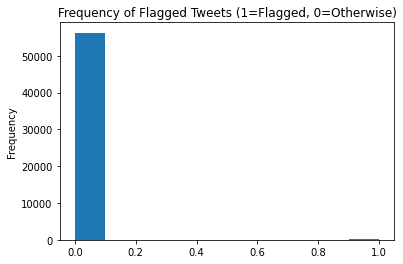

In [ ]:
tweets["is_flagged"].astype("float").plot.hist(title="Frequency of Flagged Tweets (1=Flagged, 0=Otherwise)")

Above is a plot of tweets that Twitter had flagged due to violations of their content policy. The column representing the count of posts that were flagged is so small that one can barely even register its existence. This is suprising considering how controversial the former president has been. Below is the number of tweets that were flagged, which is diminutive compared to the >56,000 tweets he composed since 2009.

In [ ]:
"Number of flagged tweets: %i" % sum(tweets["is_flagged"] == True)

'Number of flagged tweets: 304'

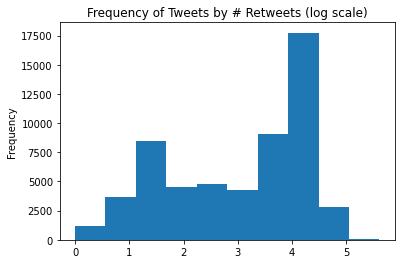

In [ ]:
np.log10(tweets["retweets"]+1).plot.hist(title="Frequency of Tweets by # Retweets (log scale)")

The histogram above illustrates the influence Trump had in the Twitter community. This plot is a histogram of the number of times a user on the platform had retweeted (posted) a tweet sent by Trump. It is more convenient to represent this on a log scale due to the great deal of variation of retweets in his posts. A large portion of his posts were retweeted on the order of 10,000 times, with some on the order of 100,000 times. However, a significant portion of tweets had only a handfull to a few hundred retweets. This implies some issues he presented were more popular than others. 

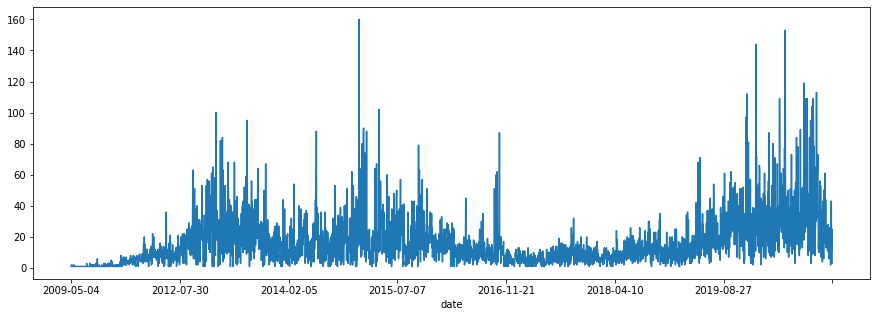

In [ ]:
tweets.groupby("date")["date"].count().plot.line(figsize=(15,5)) #announced candidacy June 16, 2015

This is a plot of the number of posts published by Trump every day since 2009. Trump was active on the platform - well before he announced his candidacy on June 16, 2015. In fact, it appears that his most active day was a few months prior to that announcement.

### Plan of Analysis

Based on the initial exploration of the data, I believe that it would be best to discard tweets posted before 2015 because these posts are likely not political and therefore uninteresting in this study. I had originally considered keeping them, but considering that he had been highly active on twitter before his political career, these posts would likely detract from the political message he had spread on the platform.

In addition, many of Trumps tweets were not actually composed by himself. Instead, these were originally tweeted by someone else, with whom Trump agreed and posted to his account. I want to know what original topics were Trump's.

Based on the analysis of retweets, it is promising that clear clusters exist in the data. Intuitively, ideas presented in a popular tweet are more likely to be topics in many other tweets to come.

In [ ]:
tweets.drop_duplicates("text", inplace=True)
tweets = tweets[tweets["is_retweet"] == False]
tweets = tweets[tweets['date'] >= "2015-01-01"]

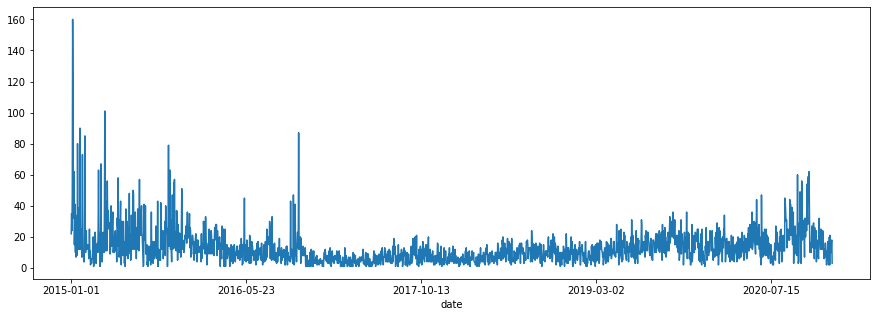

In [ ]:
tweets.groupby("date")["date"].count().plot.line(figsize=(15,5))

It seems that many tweets he posted during his presidency were retweets. This is apparent considering that many spikes in tweets are gone. Because there were few duplicates, it is unlikely that the reduction was because of these.

## Preprocessing

Text can be messy and difficult for a model to work with. This is especially true considering that social media text can be riddled with hyperlinks, typos and special characters, such as emoticons. Therefore, text needs to be forged into a format that a model can easily work with. This is typically done over several steps until the text can be represented as vectors. The code below:

1. Removes hyperlinks
2. Lowercases all text
3. Removes hashtag symbols and other special characters
4. Removes small words with length less than 4. Most English words shorter than this limit typically do not convey much information (e.g. the, I, him, a, we, etc.)

In [ ]:
text = np.array(tweets['text'])
text = [re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)', '', t) for t in text]
text = [t.lower() for t in text]
text = [" ".join([word for word in t.split(" ") if len(word) > 0 and word[0] != "#"]) for t in text]
text = [re.sub(r'[^0-9a-z ]+', '', t) for t in text]
text = [" ".join([word for word in t.split(" ") if len(word) > 3]) for t in text]
text = [t for t in text if t != ""]

In [ ]:
"Length of Pre-processed text %i" % len(text)

'Length of Pre-processed text 26463'

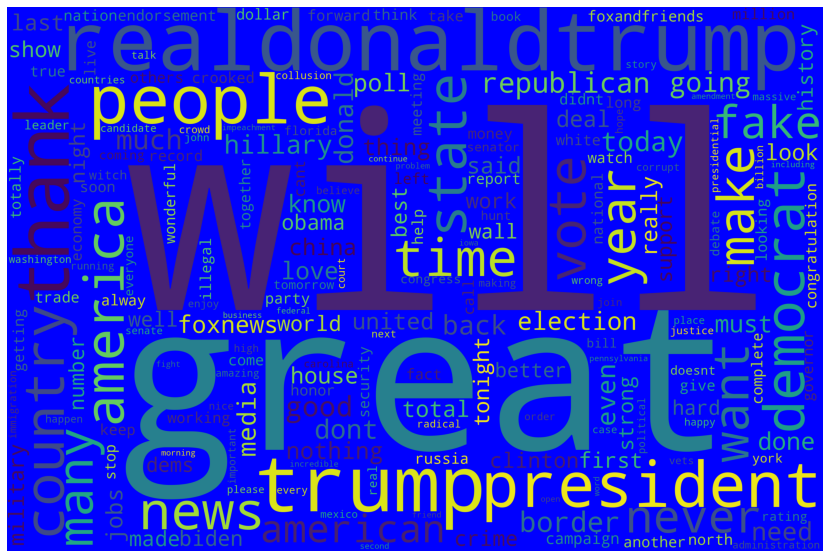

In [ ]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='blue', collocations=False).generate(" ".join(text))
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

Above is a wordcloud displaying the most frequent words in the processed corpus. The word "will" is very common. I had thought about removing this from the text, but this simple word does have a lot of meaning. Many politicians talk frequently in the future tense about what they want to change in terms of policy (e.g. I will build a border wall!). The word "Great" is also common, likely stemming from his campaign slogan "Make America Great Again!".  

## Unsupervised Analysis of the Tweets

The tweets can now be passed to an unsupervised machine learning model to identify common topics. This particular model is known as ```BERTopic```. Documentation can be found [here](https://maartengr.github.io/BERTopic/index.html). The model is based off of a neural network model that was created and pre-trained by Google for use in processing natural language. 

Bidirectional Encoder Representations from Transformers (BERT) takes as input text and transforms it into a vector embedding that is then passed as input to a recurrent neural network. The model was trained on a corpus of Wikipedia articles and books. BERT is typically used for classification tasks, but it can also be used to extract features from a corpus passed to it. These features can then be represented in high-dimensional space as vectors, which can then be grouped into clusters.

This method is relatively fast, especially when training is conducted using a Graphics Processing Unit (GPU).

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(text)

Batches:   0%|          | 0/827 [00:00<?, ?it/s]

2022-06-16 01:47:31,488 - BERTopic - Transformed documents to Embeddings
2022-06-16 01:48:10,859 - BERTopic - Reduced dimensionality
2022-06-16 01:51:06,644 - BERTopic - Clustered reduced embeddings


Using ```BERTopic```, we can visualize the clusters in 2D space. This is done through dimensionality reduction. Below is a plot of the various clusters. Many of these clusters overlap in 2D, but are separable in higher dimensions. However, I think that there is still too much overlap among the clusters identified by the algorithm. In addition, space between clusters is minimal. I would like to see clusters that are far apart from one another.

In [ ]:
topic_model.visualize_topics()

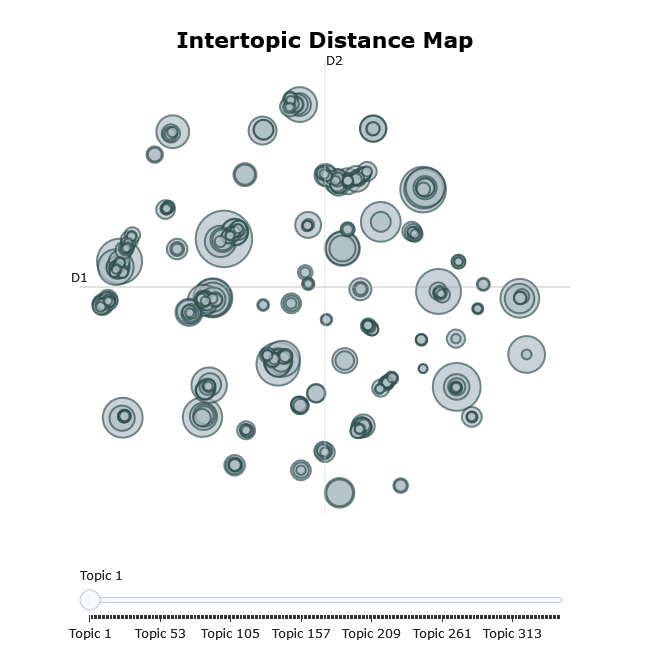

### Hyperparameter Tuning

Let us reduce the number of clusters until each cluster is reasonably distinct.

In [ ]:
topic_model.save("full_trump")

In [ ]:
topic_model_100 = BERTopic.load("full_trump")
topics_100, probs_100 = topic_model_100.reduce_topics(text, topics, probs, nr_topics=100)
topic_model_100.visualize_topics()

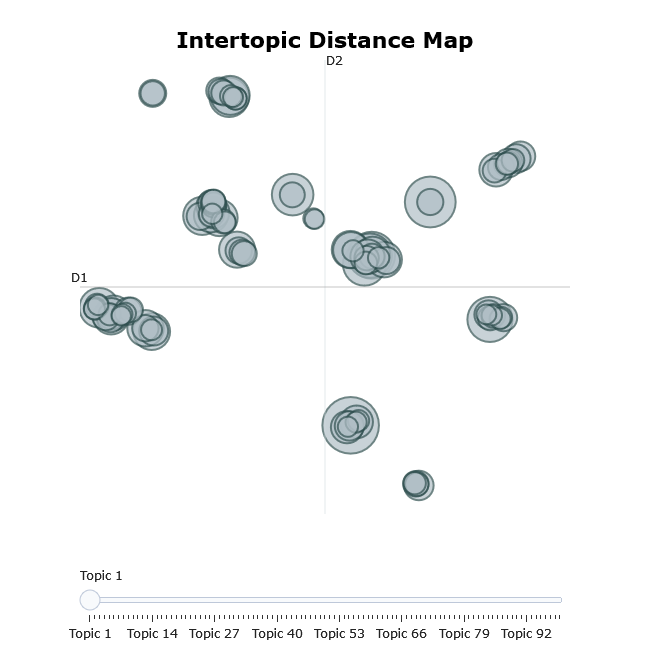

The model with 100 clusters is better than full model. However, the clusters are still somewhat close to one another.

In [ ]:
topic_model_50 = BERTopic.load("full_trump")
topics_50, probs_50 = topic_model_50.reduce_topics(text, topics, probs, nr_topics=50)
topic_model_50.visualize_topics()

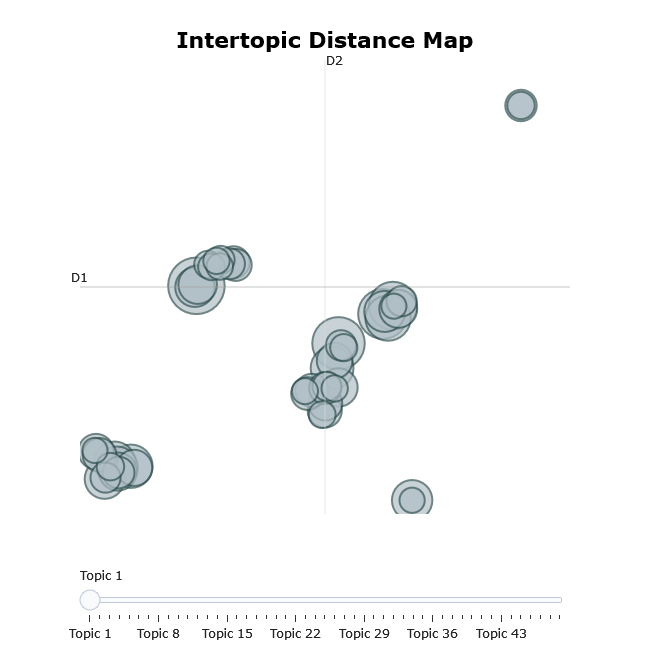

The 50 cluster model is even better. There appears to be 5 distinct super-clusters represented here, each being significantly different from each other. There is a lot of cluster overlap, however. 

In [ ]:
topic_model_30 = BERTopic.load("full_trump")
topics_30, probs_30 = topic_model_30.reduce_topics(text, topics, probs, nr_topics=30)
topic_model_30.visualize_topics()

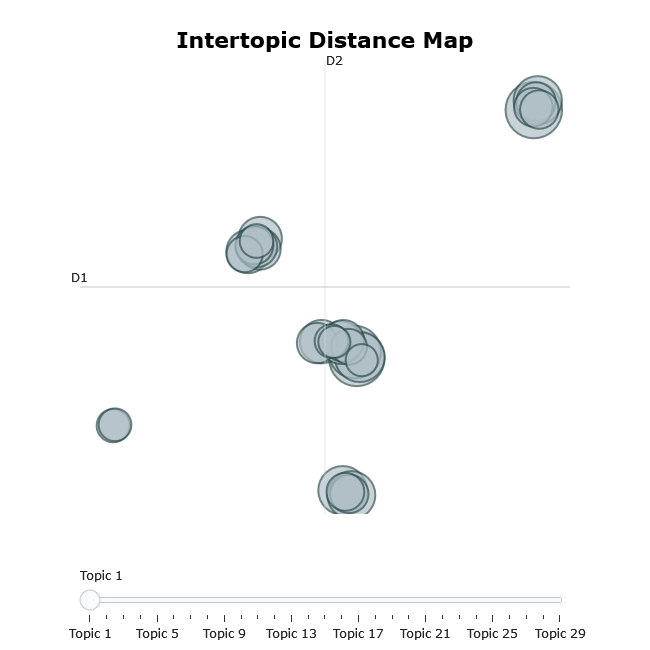

The model with 30 topics does not appear to be much better than the 50 topic model. It is also possible that topics represented in this model are too general and perhaps difficult to interpret.

## Results and Analysis

Below is a plot showing the heirarchy of the topics in the model with 50 topics. There are approximately 10 general clusters of topics that all have intra-cluster similarity of 0.5 to 1.0. Based on this plot and the previous cluster plots, I believe that the model grouping tweets into 50 clusters is the best. From my understanding, these clusters of topics represent:



1. Trump's visits on the campaign trail. Trump has been known for holding rallies, both while campaigning and in office.

2. Topics related to the Middle East and Islam.

3. Various issues and policies that Trump ran on

4. Correspondences and plesantries

5. Tweets about his place in the polls and his criticisms of the election process

6. His response to his political opposition. Various insults towards opposing politicians and reactions to criticisms of scandals he was accused of being a part of.

7. Healthcare, health-related topics and topics about the Supreme Court. I think the latter is lumped in with the former because of the frequent occurance of the word "cases". That word is also common when describing the Coronavirus pandemic.

8. The state of the economy

9. His interactions with the news media and public announcements.

10. Talking about other people

In [ ]:
topic_model_50.visualize_hierarchy()

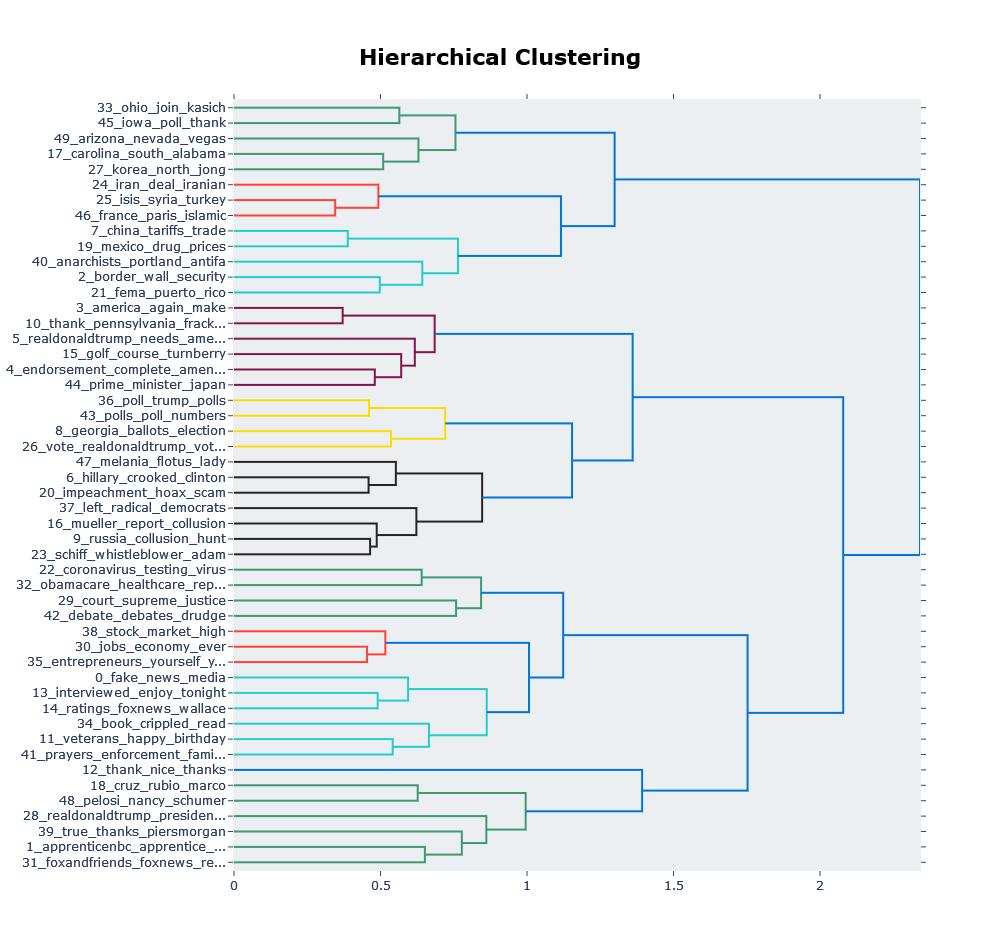

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
topic_model_50.save("topic_model_50") #save the model for future use

In [ ]:
topic_model_50 = BERTopic.load("drive/MyDrive/topic_model_50") #load to make sure the model was saved

Let us take a look at words that are associated with each topic identified by the algorithm. The number one topic that the former president tweeted about are criticisms of the news media (Topic #0). Oftentimes, he would claim that criticisms against him from the media were unfair and untrue.


It is also notable that he would frequently post about The Apprentice during his political career(Topic #1). The Apprentice was a reality show that the former president hosted. In the show, various people would be given business related challenges and Trump would judge the contestants on their work. This was how the former president gained respect amoung many Americans, as he was depicted as a talented businessperson.


There are several topics about his policies. One of his most famous was a plan to build a wall separating the United States and Mexico (Topic #2). He claims this is necessary because the border is not well-guarded and is a conduit for criminals to come through (Topic #19). He also makes mention of his policies regarding China and trade tarrifs (Topic #7). Related to this are his criticisms of that country's handling of Coronavirus (Topic #22). He would then go on to promote himself on his handling of the pandemic.

He claimed that the United States was being "ripped off" by foreign trade agreements. Many Americans have been upset by the offshoring of jobs, especially Americans who lost their manufacturing jobs in the northestern midwest, known as the Rust Belt. He also appealed to American farmers, whom he claimed suffered from unfair trade agreements. Once he had renegotiated these deals, he would claim that the economy was booming (Topic #30).

Another policy he would promote is law and order, which he claimed his opposition was against (Topic #37). In addition, he would promote gun rights, which are discussed in the Second Amendment of the U.S. Constitution (Topic #4). Related to these topics is his appeal to military service members (Topic #11).


Trump was famous for his blunt accusations and fierce attacks against his opposition. It seems that alleged scandals against his 2016 Democratic opponent Hillary Clinton destroying criminal evidence was a common topic. He gave her the nickname "Crooked Hillary". Additionally, he would criticize her on her actions as Secretary of State (Topic #25). In addition, he criticized the Obama Administration (Topic #24, Topic #32). He would also go after his Republican opponents in the primaries and congressional Democrats (Topic #18, Topic #48). 


The former president's opponents would frequently accuse him of colluding with the Russians. Claiming that they helped him become president by influencing the election and promoting him on social media. Various investigations were carried out to address this. Trump would frequently defend himself against those accusations (Topic #9). He would frequently criticize congressman Adam Schiff, who had been accusing him of wrongdoing (Topic #23).

Finally, Trump would frequently post about favorable polling data that would support the notion that he would win the upcomming election (Topic #36). However, he lost the 2020 election. He would dispute this and claim that the election was rigged (Topic #8). This is what eventually led to his being banned from Twitter.

In [ ]:
for i in range(50):
  print("Topic #%i" % (i))
  print([t[0] for t in topic_model_50.get_topic(i)])
  print("\n")

Topic #0
['fake', 'news', 'media', 'failing', 'nytimes', 'story', 'they', 'sources', 'dishonest', 'times']


Topic #1
['apprenticenbc', 'apprentice', 'realdonaldtrump', 'show', 'celebrity', 'ivankatrump', 'season', 'tonight', 'kenyamoore', 'geraldo']


Topic #2
['border', 'wall', 'security', 'democrats', 'southern', 'daca', 'immigration', 'want', 'built', 'borders']


Topic #3
['america', 'again', 'make', 'michigan', 'great', 'safe', 'will', 'together', 'lets', 'thank']


Topic #4
['endorsement', 'complete', 'amendment', 'total', 'vets', 'second', 'congressman', 'strong', 'military', 'virginia']


Topic #5
['realdonaldtrump', 'needs', 'america', 'country', 'president', 'need', 'make', 'again', 'trump', 'please']


Topic #6
['hillary', 'crooked', 'clinton', 'emails', 'bernie', 'sanders', 'email', 'judgement', 'deleted', '33000']


Topic #7
['china', 'tariffs', 'trade', 'farmers', 'deal', 'countries', 'with', 'dollars', 'steel', 'product']


Topic #8
['georgia', 'ballots', 'election', 'r

The following is code that returns some of Trump's tweets that have been assigned to each respective cluster. These tweets are the best representatives of their respective cluster. These example tweets are not displayed because some of them may be offensive. After reading many of these tweets, it became apparent that there were common patterns. He would: 

1. Criticise his opposition - whether it be news outlets, opponents or the Democratic party in general
2. Promote his policies
3. Inform his audience about upcomming events such as rallies and interviews
4. Defend himself in regards to his scandals
5. Give condolences to victims of trageties and celebrate hollidays

In [ ]:
examples = {}

for t in tweets['text']:
  if len(examples.keys()) >= 50:
    break
  if len(t.split(" ")) < 2:
    continue
  similar_topics, similarity = topic_model_50.find_topics(t, top_n=1)
  key = similar_topics[0]
  
  sim = similarity[0]
  if key not in examples:
    examples[key] = (t,sim)
  elif examples[key][1] < sim:
    examples[key] = (t,sim)


In [ ]:
examples

In [ ]:
topic_model_50.visualize_heatmap( width=600, height=600)

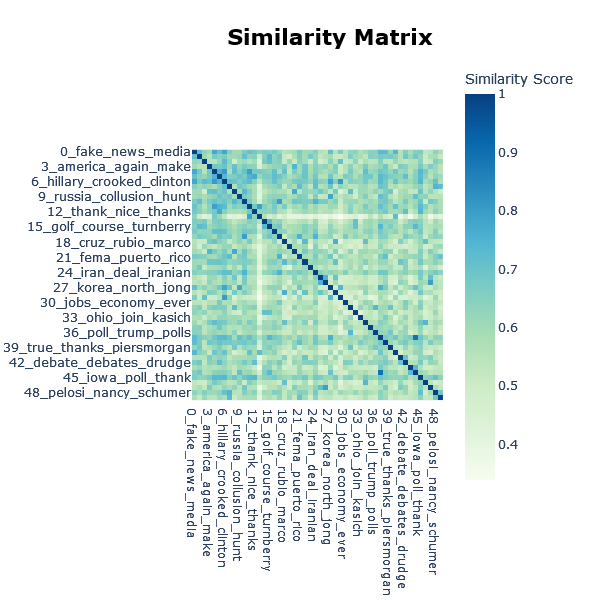

The similarity matrix above indicates that there is good separation of topics. Most of the topics are fairly different from one another. However, there does seem to be a relatively high degree of similarity among topics in the upper left corner. Below is a zoomed-in representation of this. It appears that Topic #4 shares a lot in common with other topics (Topic #0, Topic #5, Topic #6, Topic #11). What they have in common is that they are all topic related to selling the American people on voting for him. Included are campaign slogans, appeals to veterans, policies on gun rights, and criticisms of his 2016 opponent Hillary Clinton.

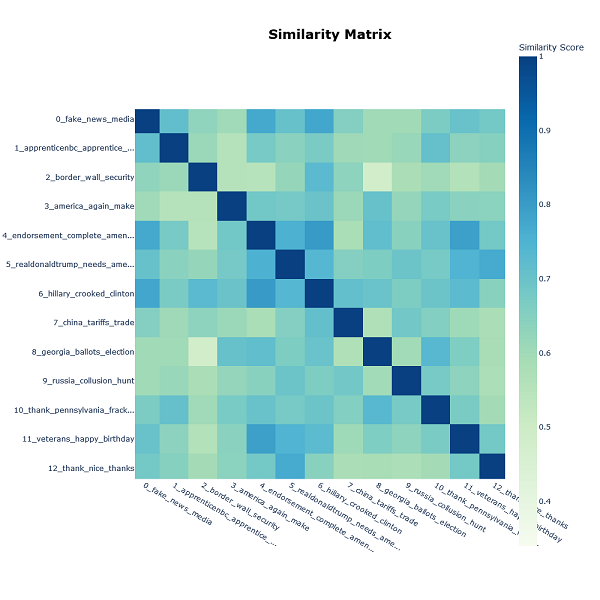

## Conclusion

This analysis has shed some light onto the opinions of a former U.S. president and the opinions of the people who elected him into office. It is apparent that Trump and his movement are populist in nature. They are opposed to globalism and are patriotic. This can be summed up by the common campaign slogans "Make America Great Again!" and "America First!".

Most of his posts were retweeted 10,000 times or more, some in the hundreds of thousands. His ideas are not on the fringe of U.S. politics, as many commentators had suggested. Many of those who support the former president are resentful in regards to the offshoring of jobs, illegal immigration and international trade agreements. Trump promised these disgruntled folks that he would fix these supposed problems.

Many Americans feel that the national news outlets are unfair, biased and do not serve the nation's best interests. Many have also felt that they have been betrayed by their leaders. I believe that his vicious and rude attacks against the Democrats and the news outlets satisfied many of these disgruntled Americans. However, it has also alientated Americans politically from one another, increasing polarization in the country.

### Future Work and Improvements

It would be interesting to know which topics were popular during certain periods of time while the former president was on Twitter. This could shed light onto what topics were popular and how they gave way to newer topics. Public opinion is not static. I would like to see how it has evolved over the years.

It may also be interesting to analyze the tweets of other prominant leaders to better gauge overall public opinion.

### Critical Reflection

This study is somewhat narrow in scope. It only represents the opinions of one man directly and projects these opinions onto the broader American political sphere. When reading this study, keep in mind that these are the opinions of only a subset of Americans. 

The BERTopic model is only one model that can be used to analyze these data. It is possible that there are better models out there. One such model is Latent Dirichlet Allocation (LDA). This model has several configurable hyperparameters that may produce a better model than the one used in this study. However, I believe that the BERTopic model performed very well at summarizing the corpus.